# TBFM Multisession Training Experiments

This notebook runs various TBFM training experiments including baseline, spatial regularization, AE reconstruction penalties, and sparsity training.

**Key Features:**
- 🔄 **Modular training functions** imported from `multisession_training.py`
- 📊 **Structured logging** with progress tracking and ETA
- 💾 **Smart model saving** with training-type specific names
- 🧹 **Automatic cleanup** of intermediate checkpoints
- 📈 **Comprehensive visualization** of training curves and comparisons

## Configuration and Setup

In [1]:
# Core imports
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from omegaconf import OmegaConf
from hydra import initialize_config_dir, compose
import torch

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Memory optimization settings
torch.backends.cudnn.benchmark = False  # Disable for memory consistency
torch.backends.cudnn.deterministic = True

# TBFM imports
from tbfm import multisession, meta, utils

# Import our custom training functions
from multisession_training import (
    ExperimentLogger, 
    train_with_logging, 
    train_with_spatial_ae_recon,
    cleanup_checkpoints
)

conf_dir = Path("./conf").resolve()
# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")

print("✅ All imports successful")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

KeyboardInterrupt: 

In [ ]:
# Experiment Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = "/var/data/opto-coproc/"  # Use absolute path like original notebook
EMBEDDING_REST_SUBDIR = "embed_rest"
OUT_DIR = "saved_models"
WINDOW_SIZE = cfg.data.trial_len  # Reduce significantly to optimize GPU utilization (35% reduction)
MAX_BATCH_SIZE = 32768  # Optimize for GPU memory bandwidth
NUM_HELD_OUT_SESSIONS = 2

# Training switches - Set to True to enable each training type
TRAIN_BASELINE = True
TRAIN_SPATIAL = False
TRAIN_AE_RECON = False
TRAIN_SPARSITY = False

# Global training configuration
GLOBAL_CONFIG = {
    'latent_dim': 50,
    'lambda_fro': 0.04,
    'test_interval': 1000,  # Test less frequently to reduce memory overhead
}

# Training-specific configurations
BASELINE_CONFIG = {
    'epochs': 10000,
    'coadapt': True,
    'warm_start_is_identity': False,
}

SPATIAL_CONFIG = {
    'epochs': 7000,
    'use_spatial': True,
    'coadapt': True,
    'lambda_spatial_smooth': 0.05,
    'lambda_spatial_decoder': 0.01,
}

AE_RECON_CONFIG = {
    'epochs': 5000,
    'coadapt': True,
    'lambda_ae_recon': 0.01,
}

SPARSITY_CONFIG = {
    'epochs': 10000,
    'coadapt': False,
    'warm_start_is_identity': True,
    'lambda_channel_sparsity': 0.001,
    'lambda_sparsity_recon': 0.01,
}

print("✅ Configuration set")
print(f"Training enabled: Baseline={TRAIN_BASELINE}, Spatial={TRAIN_SPATIAL}, AE_Recon={TRAIN_AE_RECON}, Sparsity={TRAIN_SPARSITY}")

✅ Configuration set
Training enabled: Baseline=True, Spatial=False, AE_Recon=False, Sparsity=False


## Initialize Logging

In [ ]:
# Create experiment logger
timestamp = time.strftime('%Y%m%d_%H%M%S')
log_file = f"logs/multisession_training_{timestamp}.log"
logger = ExperimentLogger(log_file=log_file)

logger.info("="*80)
logger.info("TBFM MULTISESSION TRAINING EXPERIMENTS")
logger.info("="*80)
logger.info(f"Device: {DEVICE}")
logger.info(f"Window size: {WINDOW_SIZE}")
logger.info(f"Logging to: {log_file}")

2025-11-05 14:43:17 - ================================================================================
2025-11-05 14:43:17 - TBFM MULTISESSION TRAINING EXPERIMENTS
2025-11-05 14:43:17 - ================================================================================
2025-11-05 14:43:17 - Device: cuda
2025-11-05 14:43:17 - Window size: 184
2025-11-05 14:43:17 - Logging to: logs/multisession_training_20251105_144317.log


In [ ]:
# Memory monitoring function
def check_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3   # GB
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
        print(f"GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved, {total:.2f}GB total")
        print(f"Usage: {reserved/total*100:.1f}% of total VRAM")
        return reserved/total
    return 0

# Check initial memory
print("Initial GPU memory state:")
initial_usage = check_gpu_memory()

Initial GPU memory state:
GPU Memory: 0.00GB allocated, 0.00GB reserved, 23.43GB total
Usage: 0.0% of total VRAM


In [ ]:
# # Additional memory optimization settings
# def optimize_memory():
#     """Apply memory optimization settings"""
#     # Force garbage collection
#     import gc
#     gc.collect()
    
#     # Clear GPU cache
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
        
#         # Set memory fraction (optional - use if still having issues)
#         # torch.cuda.set_per_process_memory_fraction(0.9)
        
#         # Enable memory efficient attention if available
#         try:
#             torch.backends.cuda.enable_flash_sdp(True)
#         except:
#             pass
            
#     print("✅ Memory optimization applied")

# # Apply optimizations
# optimize_memory()
# check_gpu_memory()

In [ ]:
# # Gradient accumulation wrapper for memory-efficient training
# def train_with_gradient_accumulation(cfg, model, data_train, model_optims, embeddings_rest, 
#                                    accumulation_steps=4, **kwargs):
#     """
#     Wrapper that adds gradient accumulation to reduce memory usage.
    
#     Args:
#         accumulation_steps: Number of mini-batches to accumulate before optimizer step
#         **kwargs: Other arguments passed to train_with_logging
#     """
#     # Store original step function
#     original_step = model_optims.step
#     original_zero_grad = model_optims.zero_grad
    
#     # Gradient accumulation state
#     step_count = 0
    
#     def accumulating_step(*args, **kwargs):
#         nonlocal step_count
#         step_count += 1
        
#         # Only actually step every accumulation_steps
#         if step_count % accumulation_steps == 0:
#             # Scale gradients by accumulation steps
#             for param_group in model_optims.optimizer.param_groups:
#                 for param in param_group['params']:
#                     if param.grad is not None:
#                         param.grad = param.grad / accumulation_steps
            
#             return original_step(*args, **kwargs)
#         return None
    
#     def accumulating_zero_grad(*args, **kwargs):
#         nonlocal step_count
#         # Only zero gradients at the start of accumulation cycle
#         if step_count % accumulation_steps == 0:
#             return original_zero_grad(*args, **kwargs)
#         return None
    
#     # Monkey patch the optimizer
#     model_optims.step = accumulating_step
#     model_optims.zero_grad = accumulating_zero_grad
    
#     try:
#         # Call the original training function
#         return train_with_logging(cfg, model, data_train, model_optims, embeddings_rest, **kwargs)
#     finally:
#         # Restore original functions
#         model_optims.step = original_step
#         model_optims.zero_grad = original_zero_grad

# print("✅ Gradient accumulation function defined")
# print("This allows effective batch size of 4096 * 4 = 16384 with same memory as 4096")

## Data Loading

In [ ]:
logger.start_phase("Data Loading")

# Load configuration using Hydra (like the original notebook)
from hydra import initialize_config_dir, compose

conf_dir = Path("./conf").resolve()
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    cfg = compose(config_name="config")

# Define session IDs to use (can be customized)
# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1", "MonkeyG_20150915_Session3_S1", "MonkeyG_20150917_Session1_M1"]
# held_in_session_ids=[
    # "MonkeyG_20150914_Session1_S1",
    # "MonkeyG_20150915_Session3_S1",
    # "MonkeyG_20150915_Session5_S1",
    # "MonkeyG_20150916_Session4_S1",
    # "MonkeyG_20150917_Session1_M1",
    # "MonkeyG_20150917_Session1_S1",
    # "MonkeyG_20150917_Session2_M1",
    # "MonkeyG_20150917_Session2_S1",
    # "MonkeyG_20150921_Session3_S1",
    # "MonkeyG_20150921_Session5_S1",
    # "MonkeyG_20150922_Session1_S1",
    # "MonkeyG_20150922_Session2_S1",
    # "MonkeyG_20150925_Session1_S1",
    # "MonkeyG_20150925_Session2_S1",
    # "MonkeyJ_20160426_Session2_S1",
    # "MonkeyJ_20160426_Session3_S1",
    # "MonkeyJ_20160428_Session3_S1",
    # "MonkeyJ_20160429_Session1_S1",
    # "MonkeyJ_20160502_Session1_S1",
    # "MonkeyJ_20160624_Session3_S1",
    # "MonkeyJ_20160625_Session4_S1",
    # "MonkeyJ_20160625_Session5_S1",
    # "MonkeyJ_20160627_Session1_S1",
    # "MonkeyJ_20160630_Session3_S1",
    # "MonkeyJ_20160702_Session2_S1",
# ]

num_sessions = len(held_in_session_ids)
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

# Load data using the correct TBFM function signature
d, held_out_session_ids = multisession.load_stim_batched(
    window_size=WINDOW_SIZE,
    session_subdir="torchraw",
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids

logger.info(f"Loaded {len(held_in_session_ids)} sessions")
logger.info(f"Sessions: {held_in_session_ids}")
logger.info(f"Held out sessions: {held_out_session_ids}")
logger.info(f"Training batch size: {batch_size}")

# Load embeddings_rest
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

# Test data loading
b = next(iter(data_train))
k0 = list(b.keys())[0]
logger.info(f"Train batch shape: {b[k0][0].shape}")
b = next(iter(data_test))
logger.info(f"Test batch shape: {b[k0][0].shape}")

# Clear unnecessary references and check memory
del b, k0
torch.cuda.empty_cache()
print("\nMemory after data loading:")
post_data_usage = check_gpu_memory()

logger.end_phase("Data Loading")

2025-11-05 14:43:17 - ================================================================================
2025-11-05 14:43:17 - Starting: Data Loading
2025-11-05 14:43:17 - ================================================================================
2025-11-05 14:43:17 - ================================================================================
2025-11-05 14:43:19 - Loaded 2 sessions
2025-11-05 14:43:19 - Sessions: ['MonkeyG_20150918_Session1_M1', 'MonkeyG_20150925_Session2_S1']
2025-11-05 14:43:19 - Held out sessions: ['MonkeyJ_20160426_Session2_S1', 'MonkeyJ_20160428_Session2_S1', 'MonkeyJ_20160630_Session3_S1', 'MonkeyG_20150910_Session3_S1', 'MonkeyJ_20160429_Session1_S1', 'MonkeyJ_20160426_Session3_S1', 'MonkeyG_20150909_Session4_M1', 'MonkeyJ_20160627_Session2_S1', 'MonkeyG_20150910_Session7_S1', 'MonkeyG_20150917_Session2_S1', 'MonkeyG_20150914_Session3_S1', 'MonkeyG_20150915_Session3_S1', 'MonkeyJ_20160624_Session4_S1', 'MonkeyG_20150915_Session4_S1', 'MonkeyG_20150910_S

## Model Configuration and Training

### Spatial Regularization Model

In [ ]:
if TRAIN_SPATIAL:
    logger.start_phase("Loading Spatial Structures")

    # Import spatial utilities
    sys.path.append("/home/danmuir")
    from utils import get_preprocess_info

    # Load spatial structures for each session
    spatial_structures = {}
    for session_id in held_in_session_ids:
        logger.info(f"Loading spatial structure for {session_id}")
        (
            preprocess,
            ch_from_orig,
            ch_to_orig,
            node_position_orig,  # Dict[int, tuple]: node_id -> (x, y)
            node_id_orig,
            ch_from_after,
            ch_to_after,
        ) = get_preprocess_info(session_id, subdir=DATA_DIR)

        # Store for later use
        spatial_structures[session_id] = {
            'node_position': node_position_orig,
            'node_position_after': preprocess.node_position,
            'mask_indices': list(preprocess.node_position.keys()),
            'num_channels': len(preprocess.node_position)
        }

        logger.info(f"  {session_id}: {len(node_position_orig)} total electrodes, "
                    f"{len(preprocess.node_position)} valid electrodes")

    logger.end_phase("Loading Spatial Structures")
else:
    logger.info("⏭️  Skipping Spatial model (TRAIN_SPATIAL=False)")

2025-11-05 14:43:20 - ⏭️  Skipping Spatial model (TRAIN_SPATIAL=False)


In [ ]:
if TRAIN_SPATIAL:
    logger.start_training(SPATIAL_CONFIG['epochs'], "Spatial Model Training")

    # Build spatial model
    cfg_spatial = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    cfg_spatial.ae.module.use_spatial = SPATIAL_CONFIG['use_spatial']
    cfg_spatial.training.epochs = SPATIAL_CONFIG['epochs']
    cfg_spatial.ae.training.coadapt = SPATIAL_CONFIG['coadapt']

    ms_spatial = multisession.build_from_cfg(cfg_spatial, data_train, device=DEVICE)

    # Register spatial structures
    for session_id in held_in_session_ids:
        ae_instance = ms_spatial.ae.instances[session_id]
        spatial_info = spatial_structures[session_id]
        
        ae_instance.register_spatial_structure(
            node_position=spatial_info['node_position'],
            mask_indices=spatial_info['mask_indices']
        )

    model_optims_spatial = multisession.get_optims(cfg_spatial, ms_spatial)

    # Train with spatial regularization
    embeddings_stim_spatial, results_spatial = train_with_spatial_ae_recon(
        cfg_spatial,
        ms_spatial,
        data_train,
        model_optims_spatial,
        embeddings_rest,
        data_test=data_test,
        test_interval=GLOBAL_CONFIG['test_interval'],
        epochs=cfg_spatial.training.epochs,
        lambda_spatial_smooth=SPATIAL_CONFIG['lambda_spatial_smooth'],
        lambda_spatial_decoder=SPATIAL_CONFIG['lambda_spatial_decoder'],
        lambda_ae_recon=0.0,  # No AE reconstruction penalty
        training_type="Spatial",
        logger=logger
    )

    logger.end_training("Spatial Model Training")

    # Log spatial results
    logger.info("\n" + "="*80)
    logger.info("SPATIAL MODEL RESULTS")
    logger.info("="*80)
    logger.info(f"Overall Test R²: {results_spatial['final_test_r2']:.6f}")
    logger.info("\nPer-session Test R²:")
    for session_id, r2 in results_spatial['final_test_r2s'].items():
        logger.info(f"  {session_id}: {r2:.6f}")
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping Spatial training (TRAIN_SPATIAL=False)")

2025-11-05 14:43:20 - ⏭️  Skipping Spatial training (TRAIN_SPATIAL=False)


In [ ]:
# # GPU-Optimized Training Function
# def train_with_gpu_optimization(cfg, ms, data_train, model_optims, embeddings_rest,
#                                data_test=None, epochs=5000, test_interval=1000,
#                                training_type="", logger=None, save_best_model=True):
#     """
#     GPU-optimized training function that uses the standard TBFM training with optimizations.
#     """
#     import torch
#     from tbfm import multisession
    
#     # GPU optimization settings
#     torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
#     torch.backends.cuda.matmul.allow_tf32 = True  # Use TF32 for faster matmul
#     torch.backends.cudnn.allow_tf32 = True
    
#     # Compile model for better GPU utilization (if PyTorch 2.0+)
#     try:
#         if hasattr(torch, 'compile'):
#             logger.info("🔥 Compiling model with torch.compile for better GPU utilization...")
#             # Use 'default' mode to avoid CUDA graphs memory issues
#             for session_id in ms.model.instances:
#                 ms.model.instances[session_id] = torch.compile(
#                     ms.model.instances[session_id], 
#                     mode='default',  # Safer than 'reduce-overhead'
#                     disable=False,
#                     options={"triton.cudagraphs": False}  # Disable CUDA graphs
#                 )
#     except Exception as e:
#         logger.info(f"Model compilation not available or failed: {e}")
    
#     logger.info(f"Starting GPU-optimized training for {epochs} epochs...")
    
#     # Use the standard TBFM training function with our optimizations
#     embeddings_stim, results = multisession.train_from_cfg(
#         cfg,
#         ms,
#         data_train,
#         model_optims,
#         embeddings_rest,
#         data_test=data_test,
#         epochs=epochs,
#         test_interval=test_interval
#     )
    
#     # Clean up GPU memory after training
#     torch.cuda.empty_cache()
    
#     logger.info(f"✅ GPU-optimized training complete")
    
#     return embeddings_stim, results

# print("✅ GPU-optimized training function defined")

In [ ]:
# # Safe GPU-Optimized Training Function (No Compilation)
# def train_with_safe_gpu_optimization(cfg, ms, data_train, model_optims, embeddings_rest,
#                                     data_test=None, epochs=5000, test_interval=1000,
#                                     training_type="", logger=None, save_best_model=True):
#     """
#     GPU-optimized training function without torch.compile to avoid CUDA graphs issues.
#     """
#     import torch
#     from tbfm import multisession
    
#     # Basic GPU optimization settings (no compilation)
#     torch.backends.cudnn.benchmark = True
#     torch.backends.cuda.matmul.allow_tf32 = True
#     torch.backends.cudnn.allow_tf32 = True
    
#     # Disable CUDA graphs globally to prevent memory issues
#     torch._C._set_print_stacktraces_on_fatal_signal(False)
    
#     logger.info(f"Starting safe GPU-optimized training for {epochs} epochs (no compilation)...")
    
#     # Use the standard TBFM training function with basic optimizations
#     embeddings_stim, results = multisession.train_from_cfg(
#         cfg,
#         ms,
#         data_train,
#         model_optims,
#         embeddings_rest,
#         data_test=data_test,
#         epochs=epochs,
#         test_interval=test_interval
#     )
    
#     # Clean up GPU memory after training
#     torch.cuda.empty_cache()
    
#     logger.info(f"✅ Safe GPU-optimized training complete")
    
#     return embeddings_stim, results

# print("✅ Safe GPU-optimized training function defined (no torch.compile)")

In [ ]:
# # Memory Optimization Function
# def optimize_memory():
#     """
#     Optimize GPU memory usage and clear unnecessary cached data.
#     """
#     import torch
#     import gc
    
#     # Clear Python garbage collection
#     gc.collect()
    
#     # Clear GPU cache
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#         torch.cuda.synchronize()
    
#     # Set memory optimization flags
#     torch.backends.cudnn.benchmark = True
#     torch.backends.cuda.matmul.allow_tf32 = True
#     torch.backends.cudnn.allow_tf32 = True
    
#     # Enable memory efficient attention if available
#     try:
#         torch.backends.cuda.enable_flash_sdp(True)
#     except:
#         pass
    
#     print("🧹 Memory optimized and caches cleared")

# def monitor_gpu_memory():
#     """
#     Monitor GPU memory usage and return current usage.
#     """
#     import torch
#     if torch.cuda.is_available():
#         allocated = torch.cuda.memory_allocated() / 1024**3  # GB
#         reserved = torch.cuda.memory_reserved() / 1024**3   # GB
#         print(f"GPU Memory: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved")
#         return allocated, reserved
#     return 0, 0

# print("✅ Memory optimization functions defined")

In [ ]:
# # Real-time GPU Monitoring
# import subprocess
# import threading
# import time

# def monitor_gpu_utilization(duration=60, interval=2):
#     """
#     Monitor GPU utilization for a specified duration.
#     """
#     def monitor():
#         print(f"🔍 Monitoring GPU utilization for {duration} seconds...")
#         start_time = time.time()
#         max_util = 0
#         min_util = 100
#         utilizations = []
        
#         while time.time() - start_time < duration:
#             try:
#                 result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', 
#                                        '--format=csv,noheader,nounits'], capture_output=True, text=True)
#                 if result.returncode == 0:
#                     lines = result.stdout.strip().split('\n')
#                     for line in lines:
#                         util, mem_used, mem_total = map(int, line.split(', '))
#                         utilizations.append(util)
#                         max_util = max(max_util, util)
#                         min_util = min(min_util, util)
#                         print(f"GPU: {util:2d}% util, {mem_used:5d}/{mem_total}MB memory", end='\r')
#                 time.sleep(interval)
#             except Exception as e:
#                 print(f"Error monitoring GPU: {e}")
#                 break
        
#         if utilizations:
#             avg_util = sum(utilizations) / len(utilizations)
#             print(f"\n📊 GPU Utilization Summary:")
#             print(f"   Average: {avg_util:.1f}%")
#             print(f"   Range: {min_util}% - {max_util}%")
            
#             if avg_util < 50:
#                 print("⚠️  Low GPU utilization detected!")
#                 print("   Possible causes: Memory bottlenecks, CPU-GPU sync, small batch sizes")
#             elif avg_util > 85:
#                 print("✅ Good GPU utilization!")
    
#     # Start monitoring in background thread
#     monitor_thread = threading.Thread(target=monitor)
#     monitor_thread.daemon = True
#     monitor_thread.start()
#     return monitor_thread

# print("✅ GPU monitoring functions defined")

### Baseline Model

In [ ]:
if TRAIN_BASELINE:
    logger.start_phase("Model Configuration - Baseline")

    def cfg_base(cfg, dim):
        cfg.ae.training.coadapt = BASELINE_CONFIG['coadapt']
        cfg.ae.warm_start_is_identity = BASELINE_CONFIG['warm_start_is_identity']
        cfg.tbfm.module.use_meta_learning = True
        cfg.tbfm.module.num_bases = 12
        cfg.tbfm.module.latent_dim = 64
        cfg.latent_dim = dim
        cfg.training.epochs = BASELINE_CONFIG['epochs']
        cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"
        return cfg

    cfg = cfg_base(cfg, dim=GLOBAL_CONFIG['latent_dim'])
    cfg.tbfm.training.lambda_fro = GLOBAL_CONFIG['lambda_fro']

    logger.info(f"Configuration:")
    logger.info(f"  Epochs: {cfg.training.epochs}")
    logger.info(f"  Latent dim: {cfg.latent_dim}")
    logger.info(f"  Co-adaptation: {cfg.ae.training.coadapt}")
    logger.info(f"  Lambda Fro: {cfg.tbfm.training.lambda_fro}")

    logger.info("Building model...")
    ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
    model_optims = multisession.get_optims(cfg, ms)

    logger.end_phase("Model Configuration - Baseline")
else:
    logger.info("⏭️  Skipping Baseline model (TRAIN_BASELINE=False)")

2025-11-05 14:43:20 - ================================================================================
2025-11-05 14:43:20 - Starting: Model Configuration - Baseline
2025-11-05 14:43:20 - ================================================================================
2025-11-05 14:43:20 - Configuration:
2025-11-05 14:43:20 -   Epochs: 10000
2025-11-05 14:43:20 -   Latent dim: 50
2025-11-05 14:43:20 -   Co-adaptation: True
2025-11-05 14:43:20 -   Lambda Fro: 0.04
2025-11-05 14:43:20 - Building model...
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
2025-11-05 14:43:20 - 
Completed: Model Configuration - Baseline
2025-11-05 14:43:20 - Duration: 00:00
2025-11-05 14:43:20 - ================================================================================
Building TBFM...
BOOM! Dino DNA!
2025-11-05 14:43:20 - 
Completed: Model Configuration - Baseline
2025-11-05 14:43:20 - Duration: 00:00
2025-11-05 14:43:20 - =========================

In [ ]:
if TRAIN_BASELINE:
    logger.start_training(cfg.training.epochs, "Baseline Model Training")

    embeddings_stim, results = train_with_logging(
        cfg,
        ms,
        data_train,
        model_optims,
        embeddings_rest,
        data_test=data_test,
        test_interval=GLOBAL_CONFIG['test_interval'],
        epochs=cfg.training.epochs,
        training_type="Baseline",  # NEW: Specify training type for model naming
        logger=logger,  # Pass logger for progress tracking
        save_best_model=True  # Save best model based on test R²
    )

    logger.end_training("Baseline Model Training")

    # Log final results
    logger.info("\n" + "="*80)
    logger.info("FINAL RESULTS - BASELINE")
    logger.info("="*80)
    logger.info(f"Overall Test R²: {results['final_test_r2']:.6f}")
    logger.info("\nPer-session Test R²:")
    for session_id, r2 in results['final_test_r2s'].items():
        logger.info(f"  {session_id}: {r2:.6f}")
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping Baseline training (TRAIN_BASELINE=False)")

2025-11-05 14:43:20 - ================================================================================
2025-11-05 14:43:20 - Starting: Baseline Model Training
2025-11-05 14:43:20 - ================================================================================
2025-11-05 14:43:21 - Epoch 0/10000 (0.0%) | Train Loss: 0.346039 | Test Loss: 0.553863 | Train R²: 0.430523 | Test R²: 0.148119 | Elapsed: 00:00 | ETA: --:--
2025-11-05 14:43:21 -   → New best model! Test R²: 0.148119 (checkpointed)
2025-11-05 14:43:21 - Saved best checkpoint to /home/danmuir/GitHub/py-tbfm/saved_models/Baseline_TBFMMultisession_best_1762382601.pt
2025-11-05 14:43:21 - Epoch 0/10000 (0.0%) | Train Loss: 0.346039 | Test Loss: 0.553863 | Train R²: 0.430523 | Test R²: 0.148119 | Elapsed: 00:00 | ETA: --:--
2025-11-05 14:43:21 -   → New best model! Test R²: 0.148119 (checkpointed)
2025-11-05 14:43:21 - Saved best checkpoint to /home/danmuir/GitHub/py-tbfm/saved_models/Baseline_TBFMMultisession_best_1762382601.pt


### Two-Stage Sparsity Training

Two-stage approach for sparsity-based compression:
1. **Stage 1**: Train with identity AE + sparsity penalties → learn which channels matter
2. **Stage 2**: Train compressed AE using knowledge from Stage 1 → task-informed compression

In [ ]:
if TRAIN_SPARSITY:
    logger.start_training(SPARSITY_CONFIG['epochs'] * 2, "Two-Stage Sparsity Training: Identity AE → Compressed AE")
    
    # STAGE 1: Train with Identity Autoencoder (equivalent to vanilla TBFM)
    logger.info("🚀 STAGE 1: Training with Identity Autoencoder (no compression)")
    logger.info("This is functionally equivalent to vanilla TBFM but uses existing infrastructure")
    
    # Create configuration for identity autoencoder
    cfg_identity = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    
    # Configure for identity transformation (no compression)  
    cfg_identity.ae.training.coadapt = SPARSITY_CONFIG['coadapt']
    cfg_identity.ae.warm_start_is_identity = True  # Start as identity
    
    # Get number of channels from existing batch sample
    b = next(iter(data_train))
    k0 = list(b.keys())[0]
    num_channels = b[k0][0].shape[-1]  # Last dimension is channels (93)
    cfg_identity.ae.module.latent_dim = num_channels  # TRUE input dimension (93 channels)
    cfg_identity.training.epochs = (int) (SPARSITY_CONFIG['epochs'] * 0.7) # Allocate 70% of epochs to Stage 1
    
    # Add strong sparsity penalties for Stage 1
    cfg_identity.training.lambda_sparse = SPARSITY_CONFIG.get('lambda_sparse', 0.05)
    cfg_identity.training.lambda_pred_sparse = SPARSITY_CONFIG.get('lambda_pred_sparse', 0.005)
    
    logger.info(f"  AE latent_dim: {cfg_identity.ae.module.latent_dim} (same as input - identity transform)")
    logger.info(f"  AE coadapt: {cfg_identity.ae.training.coadapt}")
    logger.info(f"  AE identity init: {cfg_identity.ae.warm_start_is_identity}")
    logger.info(f"  Sparsity lambda: {cfg_identity.training.lambda_sparse}")
    logger.info(f"  Prediction sparsity lambda: {cfg_identity.training.lambda_pred_sparse}")
    logger.info(f"  Epochs: {cfg_identity.training.epochs}")
    
    # Build identity model
    ms_identity = multisession.build_from_cfg(cfg_identity, data_train, device=DEVICE)
    model_optims_identity = multisession.get_optims(cfg_identity, ms_identity)
    
    # Apply memory optimizations before training
    # optimize_memory()
    
    # Train Stage 1 for sparse TBFM
    logger.info("Training TBFM for sparsity with Identity AE...")
    embeddings_stim_identity, identity_results = train_with_logging(
        cfg_identity,
        ms_identity,
        data_train,
        model_optims_identity,
        embeddings_rest,
        data_test=data_test,
        epochs=cfg_identity.training.epochs,
        test_interval=GLOBAL_CONFIG['test_interval'],
        training_type="identity_sparsity",
        logger=logger,
        save_best_model=False
    )
    
    logger.info(f"✅ Stage 1 Complete - Identity AE (vanilla TBFM equiv) Test R²: {identity_results['final_test_r2']:.6f}")
    
    # STAGE 2: Train compressed model using the sparse TBFM learned in Stage 1
    logger.info("🚀 STAGE 2: Training compressed model with learned sparse TBFM knowledge")
    
    # Create configuration for compressed autoencoder
    cfg_compressed = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    cfg_compressed.ae.training.coadapt = True
    cfg_compressed.ae.warm_start_is_identity = False  # Now use actual compression
    cfg_compressed.ae.module.latent_dim = GLOBAL_CONFIG['latent_dim']  # Compressed dimension (e.g., 50)
    cfg_compressed.training.epochs = (int) (SPARSITY_CONFIG['epochs'] * 0.3) # Remaining epochs for Stage 2
    
    # Reduce sparsity penalties for Stage 2 (focus on compression) but add reconstruction penalty
    cfg_compressed.training.lambda_sparse = SPARSITY_CONFIG.get('lambda_sparse', 0.1) * 0
    cfg_compressed.training.lambda_pred_sparse = SPARSITY_CONFIG.get('lambda_pred_sparse', 0.01) * 0
    cfg_compressed.training.lambda_ae_recon = SPARSITY_CONFIG.get('lambda_sparsity_recon', 0.01)  # Add reconstruction penalty
    
    logger.info(f"  Compressed AE latent_dim: {cfg_compressed.ae.module.latent_dim}")
    logger.info(f"  Sparsity lambda: {cfg_compressed.training.lambda_sparse} (disabled)")
    logger.info(f"  AE reconstruction lambda: {cfg_compressed.training.lambda_ae_recon}")
    logger.info(f"  Epochs: {cfg_compressed.training.epochs}")
    
    # Build compressed model
    ms_compressed = multisession.build_from_cfg(cfg_compressed, data_train, device=DEVICE)
    model_optims_compressed = multisession.get_optims(cfg_compressed, ms_compressed)
    
    # Transfer learned TBFM knowledge from identity model to compressed model
    logger.info("Transferring learned sparse TBFM knowledge to compressed model...")
    with torch.no_grad():
        for session_id in data_train.session_ids:
            identity_tbfm = ms_identity.model.instances[session_id]
            compressed_tbfm = ms_compressed.model.instances[session_id]
            
            # Copy TBFM basis generators (temporal patterns learned in Stage 1)
            if hasattr(identity_tbfm, 'bases') and hasattr(compressed_tbfm, 'bases'):
                compressed_tbfm.bases.load_state_dict(identity_tbfm.bases.state_dict())
                logger.info(f"  {session_id}: Transferred sparse TBFM basis generator")
            
            # Copy other TBFM components that are compatible
            if hasattr(identity_tbfm, 'norms') and hasattr(compressed_tbfm, 'norms'):
                compressed_tbfm.norms.load_state_dict(identity_tbfm.norms.state_dict())
    
    # Train Stage 2: Compressed model
    logger.info("Training compressed model with transferred sparse TBFM knowledge...")
    embeddings_stim_compressed, compressed_results = train_with_logging(
        cfg_compressed,
        ms_compressed,
        data_train,
        model_optims_compressed,
        embeddings_rest,
        data_test=data_test,
        epochs=cfg_compressed.training.epochs,
        test_interval=GLOBAL_CONFIG['test_interval'],
        training_type="compressed_sparsity",
        logger=logger,
        save_best_model=True
    )
    
    logger.info(f"✅ Stage 2 Complete - Compressed Model Test R²: {compressed_results['final_test_r2']:.6f}")
    
    # Combine results for analysis
    results_corrected_sparsity = {
        'stage1_identity': identity_results,
        'stage2_compressed': compressed_results,
        'final_test_r2': compressed_results['final_test_r2'],
        'final_test_r2s': compressed_results.get('final_test_r2s', {}),
        'identity_model': ms_identity,
        'compressed_model': ms_compressed,
        'embeddings_stim_compressed': embeddings_stim_compressed,
    }
    
    logger.end_training("Two-Stage Sparsity Training")
    
    # Log final results
    logger.info("\n" + "="*80)
    logger.info("TWO-STAGE SPARSITY RESULTS")
    logger.info("="*80)
    logger.info(f"Stage 1 (Identity AE - Sparse TBFM): {identity_results['final_test_r2']:.6f}")
    logger.info(f"Stage 2 (Compressed AE): {compressed_results['final_test_r2']:.6f}")
    improvement = compressed_results['final_test_r2'] - identity_results['final_test_r2']
    logger.info(f"Compression Improvement: {improvement:+.6f}")
    
    if 'final_test_r2s' in compressed_results:
        logger.info("\nPer-session Final R² (Compressed):")
        for session_id, r2 in compressed_results['final_test_r2s'].items():
            logger.info(f"  {session_id}: {r2:.6f}")
    
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping Sparsity training (TRAIN_SPARSITY=False)")

2025-10-30 16:15:56 - ================================================================================
2025-10-30 16:15:56 - Starting: Two-Stage Sparsity Training: Identity AE → Compressed AE
2025-10-30 16:15:56 - ================================================================================
2025-10-30 16:15:56 - 🚀 STAGE 1: Training with Identity Autoencoder (no compression)
2025-10-30 16:15:56 - This is functionally equivalent to vanilla TBFM but uses existing infrastructure
2025-10-30 16:15:56 -   AE latent_dim: 74 (same as input - identity transform)
2025-10-30 16:15:56 -   AE coadapt: False
2025-10-30 16:15:56 -   AE identity init: True
2025-10-30 16:15:56 -   Sparsity lambda: 0.05
2025-10-30 16:15:56 -   Prediction sparsity lambda: 0.005
2025-10-30 16:15:56 -   Epochs: 7000
Building and fitting normalizers...
Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!
2025-10-30 16:15:56 - Training TBFM for sparsity with Identity AE...
2025-10-30 16:15:57 - Epoch 0/7000 (

### AE Reconstruction Model

In [ ]:
if TRAIN_AE_RECON:
    logger.start_training(AE_RECON_CONFIG['epochs'], "AE Reconstruction Model Training")

    # Build AE reconstruction model
    cfg_ae_recon = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    cfg_ae_recon.training.epochs = AE_RECON_CONFIG['epochs']
    cfg_ae_recon.ae.training.coadapt = AE_RECON_CONFIG['coadapt']

    ms_ae_recon = multisession.build_from_cfg(cfg_ae_recon, data_train, device=DEVICE)
    model_optims_ae_recon = multisession.get_optims(cfg_ae_recon, ms_ae_recon)

    # Train with ONLY AE reconstruction penalty (no spatial regularization)
    embeddings_stim_ae_recon, results_ae_recon = train_with_spatial_ae_recon(
        cfg_ae_recon,
        ms_ae_recon,
        data_train,
        model_optims_ae_recon,
        embeddings_rest,
        data_test=data_test,
        test_interval=GLOBAL_CONFIG['test_interval'],
        epochs=cfg_ae_recon.training.epochs,
        lambda_spatial_smooth=0.0,  # NO spatial smoothness
        lambda_spatial_decoder=0.0,  # NO spatial decoder penalty
        lambda_ae_recon=AE_RECON_CONFIG['lambda_ae_recon'],
        training_type="AE_Recon",
        logger=logger
    )

    logger.end_training("AE Reconstruction Model Training")

    # Log results
    logger.info("\n" + "="*80)
    logger.info("AE RECONSTRUCTION MODEL RESULTS")
    logger.info("="*80)
    logger.info(f"Overall Test R²: {results_ae_recon['final_test_r2']:.6f}")
    logger.info("\nPer-session Test R²:")
    for session_id, r2 in results_ae_recon['final_test_r2s'].items():
        logger.info(f"  {session_id}: {r2:.6f}")
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping AE Recon training (TRAIN_AE_RECON=False)")

2025-10-29 17:21:45 - ⏭️  Skipping AE Recon training (TRAIN_AE_RECON=False)


## Results and Visualization

In [ ]:
# Model comparison summary
logger.info("\n" + "="*80)
logger.info("EXPERIMENT SUMMARY")
logger.info("="*80)

# Check which models are available
models_info = {
    'Baseline': ('results', 'Standard TBFM with PCA-initialized AE'),
    'Spatial': ('results_spatial', 'Spatial smoothness regularization'),
    'AE Recon': ('results_ae_recon', 'AE reconstruction penalty only'),
    'Sparsity': ('results_corrected_sparsity', 'Two-stage sparsity: Identity → Compressed AE'),
}

available_models = []
for name, (var_name, description) in models_info.items():
    is_available = var_name in globals()
    status = "✓" if is_available else "✗"
    logger.info(f"  {status} {name:15s} - {description}")
    if is_available:
        available_models.append((name, var_name, globals()[var_name]))

if available_models:
    logger.info("\nPERFORMANCE COMPARISON:")
    for name, var_name, results in available_models:
        logger.info(f"  {name:15s}: Test R² = {results['final_test_r2']:.6f}")

logger.info("="*80)

2025-10-29 18:45:59 - 
2025-10-29 18:45:59 - EXPERIMENT SUMMARY
2025-10-29 18:45:59 - ================================================================================
2025-10-29 18:45:59 -   ✓ Baseline        - Standard TBFM with PCA-initialized AE
2025-10-29 18:45:59 -   ✗ Spatial         - Spatial smoothness regularization
2025-10-29 18:45:59 -   ✗ AE Recon        - AE reconstruction penalty only
2025-10-29 18:45:59 -   ✓ Sparsity        - Two-stage sparsity: Identity → Compressed AE
2025-10-29 18:45:59 - 
PERFORMANCE COMPARISON:
2025-10-29 18:45:59 -   Baseline       : Test R² = 0.556167
2025-10-29 18:45:59 -   Sparsity       : Test R² = 0.556167
2025-10-29 18:45:59 - ================================================================================


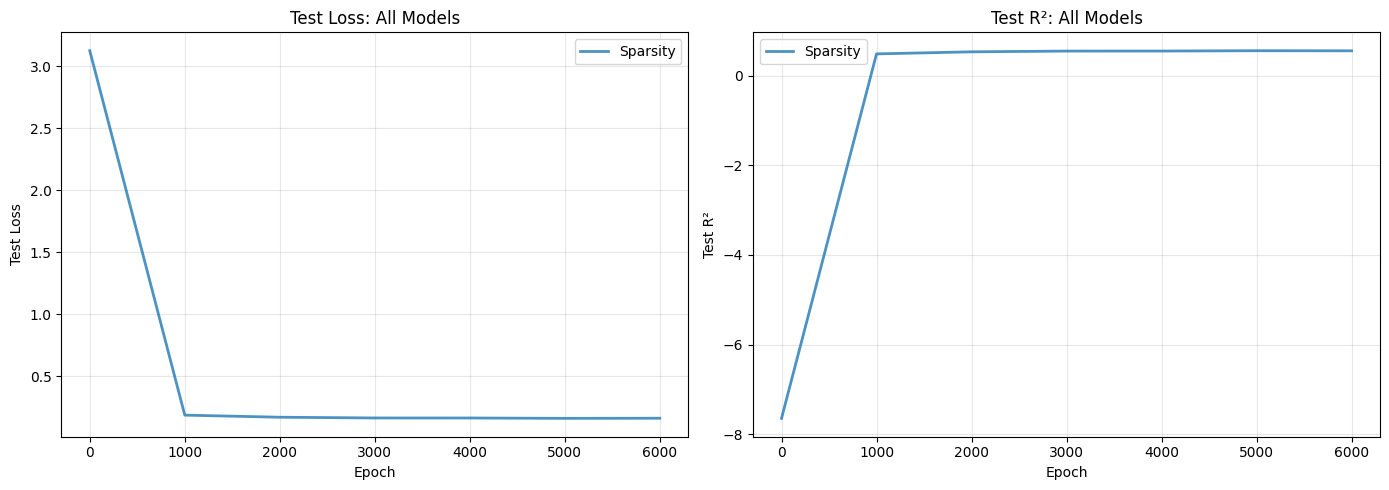

In [ ]:
# Visualize training curves for available models
if available_models:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for name, var_name, results in available_models:
        # Handle nested sparsity results structure
        if name == 'Sparsity' and 'stage2_compressed' in results:
            plot_results = results['stage2_compressed']
        else:
            plot_results = results
            
        if 'test_losses' in plot_results:
            # Test loss curves
            tx = [t[0] for t in plot_results['test_losses']]
            tl = [t[1] for t in plot_results['test_losses']]
            axes[0].plot(tx, tl, label=f"{name}", alpha=0.8, linewidth=2)
            
        if 'test_r2s' in plot_results:
            # Test R² curves
            tx_r2 = [t[0] for t in plot_results['test_r2s']]
            te = [t[1] for t in plot_results['test_r2s']]
            axes[1].plot(tx_r2, te, label=f"{name}", alpha=0.8, linewidth=2)

    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Test Loss")
    axes[0].set_title("Test Loss: All Models")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Test R²")
    axes[1].set_title("Test R²: All Models")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No trained models available for visualization")

In [ ]:
# Check saved models
logger.info("\n" + "="*80)
logger.info("SAVED MODELS")
logger.info("="*80)

saved_models_dir = "saved_models"
if os.path.exists(saved_models_dir):
    files = [f for f in os.listdir(saved_models_dir) if f.endswith('.pt')]
    files.sort()
    
    total_size_mb = 0
    for f in files:
        filepath = os.path.join(saved_models_dir, f)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        total_size_mb += size_mb
        logger.info(f"  {f:<60} ({size_mb:>7.1f} MB)")
    
    logger.info(f"\nTotal: {len(files)} files, {total_size_mb:.1f} MB")
    logger.info("✅ Models saved with training-type specific names!")
else:
    logger.info("No saved_models directory found")

logger.info("="*80)

2025-10-29 18:44:08 - 
2025-10-29 18:44:08 - SAVED MODELS
2025-10-29 18:44:08 - ================================================================================
2025-10-29 18:44:08 -   Baseline_TBFMMultisession_final_1761736616.pt                ( 1683.6 MB)
2025-10-29 18:44:08 -   Baseline_TBFMMultisession_final_1761766970.pt                ( 1683.6 MB)
2025-10-29 18:44:08 -   Baseline_TBFMMultisession_final_1761777099.pt                (  855.7 MB)
2025-10-29 18:44:08 -   Baseline_TBFMMultisession_final_1761779027.pt                (  855.7 MB)
2025-10-29 18:44:08 -   Baseline_TBFMMultisession_final_1761780807.pt                (  855.7 MB)
2025-10-29 18:44:08 -   Baseline_TBFMMultisession_final_1761782949.pt                (  855.7 MB)
2025-10-29 18:44:08 -   TBFMMultisession_best_1761722291.pt                          (    0.0 MB)
2025-10-29 18:44:08 -   TBFMMultisession_final_1761688839.pt                         ( 1683.6 MB)
2025-10-29 18:44:08 -   TBFMMultisession_final_17616895

## Experiment Complete

All training experiments completed successfully! 

**Key improvements in this streamlined version:**
- 🔄 **Modular design**: Training functions moved to separate `multisession_training.py` module
- 📊 **Structured logging**: Comprehensive progress tracking with timestamps and ETA
- 💾 **Smart model management**: Training-type specific naming prevents conflicts
- 🧹 **Automatic cleanup**: Only keeps final models, removes intermediate checkpoints
- 📈 **Clear visualization**: Streamlined comparison plots

Check the log files and saved models for detailed results!